In [1]:
import pandas as pd
import numpy as np
import networkx as nx


In [2]:
# Load networks
G_ad = nx.read_gml("../results/alzheimers_network.gml")
G_ctrl = nx.read_gml("../results/control_network.gml")


In [3]:
def network_stats(G):
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_degree": np.mean([d for _, d in G.degree()]),
        "avg_clustering": nx.average_clustering(G)
    }

stats_ad = network_stats(G_ad)
stats_ctrl = network_stats(G_ctrl)

stats_ad, stats_ctrl


({'nodes': 101,
  'edges': 1308,
  'density': 0.259009900990099,
  'avg_degree': 25.900990099009903,
  'avg_clustering': 0.8640399979361352},
 {'nodes': 105,
  'edges': 1521,
  'density': 0.2785714285714286,
  'avg_degree': 28.97142857142857,
  'avg_clustering': 0.823794358807946})

In [4]:
deg_ad = nx.degree_centrality(G_ad)
deg_ctrl = nx.degree_centrality(G_ctrl)

deg_df = pd.DataFrame({
    "gene": list(deg_ad.keys()),
    "degree_AD": list(deg_ad.values()),
    "degree_Control": [deg_ctrl.get(g, 0) for g in deg_ad.keys()]
})

deg_df["degree_diff"] = deg_df["degree_AD"] - deg_df["degree_Control"]
deg_df.sort_values("degree_diff", ascending=False).head(10)


,gene,degree_AD,degree_Control,degree_diff
55,10023828170,0.34,0.000000,0.340000
58,10023833115,0.45,0.230769,0.219231
62,10025908848,0.42,0.211538,0.208462
39,10023814509,0.40,0.211538,0.188462
40,10023814510,0.37,0.182692,0.187308
34,10023811933,0.41,0.259615,0.150385
12,10023820660,0.18,0.076923,0.103077
74,10033668859,0.46,0.384615,0.075385
68,10025911973,0.43,0.355769,0.074231
8,10023805853,0.21,0.153846,0.056154


In [5]:
from networkx.algorithms.community import greedy_modularity_communities

communities_ad = list(greedy_modularity_communities(G_ad))
communities_ctrl = list(greedy_modularity_communities(G_ctrl))

len(communities_ad), len(communities_ctrl)


(6, 4)

In [6]:
comm_sizes_ad = sorted([len(c) for c in communities_ad], reverse=True)
comm_sizes_ctrl = sorted([len(c) for c in communities_ctrl], reverse=True)

comm_sizes_ad[:5], comm_sizes_ctrl[:5]


([54, 22, 10, 7, 6], [49, 27, 22, 7])

In [7]:
largest_ad_comm = list(communities_ad[0])
len(largest_ad_comm)


54

In [8]:
G_ad_module = G_ad.subgraph(largest_ad_comm)


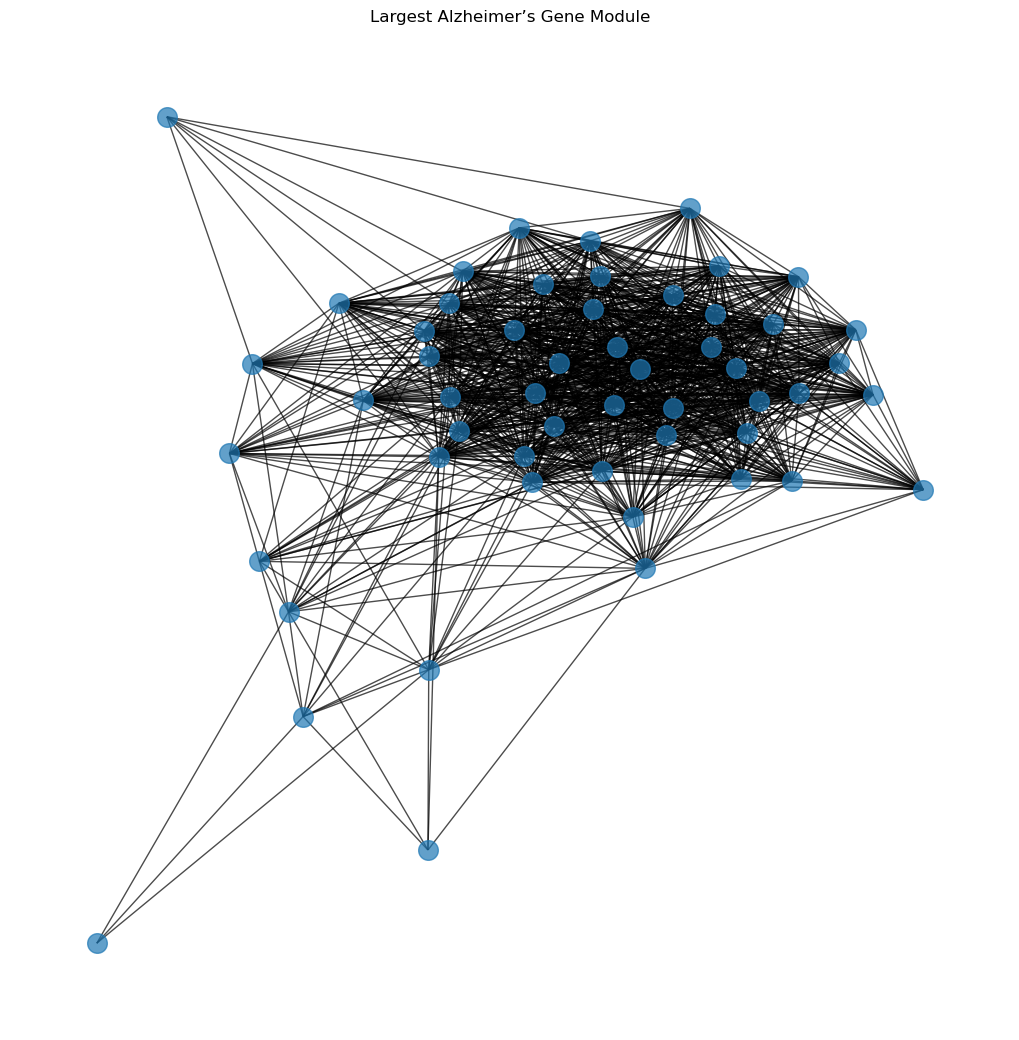

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_ad_module, seed=42)

nx.draw(
    G_ad_module,
    pos,
    node_size=200,
    with_labels=False,
    alpha=0.7
)

plt.title("Largest Alzheimer’s Gene Module")
plt.axis("off")
plt.show()


In [11]:
# Create long-format dataframe
comm_df = pd.DataFrame({
    "condition": (["AD"] * len(comm_sizes_ad)) + (["Control"] * len(comm_sizes_ctrl)),
    "community_size": comm_sizes_ad + comm_sizes_ctrl
})

comm_df.to_csv("../results/community_sizes.csv", index=False)
